In [3]:
## math, plotting
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import scipy.stats

## machine learning
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


import pickle

import sys
from os import listdir
sys.path.append('../../Beltway_Project/')
sys.path.append('../../RatterdamOpen_Project/')
sys.path.append('../DATA/')
sys.path.append('../../../ratterdam/')


import RateMapClass_William_20190308 as RateMapClass
import ratterdam_RepetitionCoreFx as CoreFx
import confounds as direction
import newAlleyBounds as bounds2

In [4]:
## convolves spikes with a gaussian window to get instantaneous firing rate
def omega(tau):
    h = (time[1]-time[0])/2
    sig_window = 50*h##30*h
    mult = 1/(((2*np.pi)**.5)*sig_window)
    return(mult*np.exp((-tau**2)/(2*sig_window**2)))

In [6]:
## Reading in file with all data
file = open('../DATA/20220405-124315_superPopulationRepetition.pickle','rb')
alldat = pickle.load(file)

In [7]:
## For each rat-day combination- Creates the following files
## 1. x position within cityblock alley/intersection 
## 2. y position within cityblock alley/intersection
## 3. Instantaneous firing rate for all neurons
## 4. Splits all data into dt(10000) timepoints, finds spike/occupancy for each time window
## 5. Time spent by the animal in each alley in each time window

## Need not run again, if files have already been created

store_dir = '../DATA/FILES/'

include_all = True  ## can be modified to include only repeating
min_dur = 10
dt = 10000 ## each time window

all_rats = list(alldat.keys())
for rat in all_rats:
    all_days = list(alldat[rat].keys())
    for day in all_days:
        print(rat, day)
        
        alley_dict = {}
        timebreaks = []
        x_within = []
        y_within = []
        boundaries = bounds2.loadAlleyBounds(rat, day)[-2]
        bound_list = list(dict.keys(boundaries))
        all_cells = list(alldat[rat][day]['units'].keys())
        data = alldat[rat][day]['units'][all_cells[0]]
        within_list = np.empty(len(data.position))
        time_counter = 0
        time_spent_alley = np.zeros(len(bound_list))
        all_time_spent_alley = np.zeros(len(bound_list))
        for i in range(len(data.position)):
            curr_time = data.position[i, 0]
            x = data.position[i, 1]
            y = data.position[i, 2]
            found = False
            for j in range(len(bound_list)): 
                alley = bound_list[j]
                ## checking if within alley/intersection
                if x > boundaries[alley][0][0] and x<= boundaries[alley][0][1]:
                    if y>boundaries[alley][1][0] and y<= boundaries[alley][1][1]:
                        alley_dict[str(x) + '_' + str(y)]= j
                        time_spent_alley[j] = time_spent_alley[j] + 1
                        found = True
                        time_counter = time_counter + 1
                        if time_counter> dt:
                            all_time_spent_alley = np.vstack((all_time_spent_alley, time_spent_alley))
                            timebreaks.append(curr_time)
                            time_counter = 0
                            time_spent_alley = np.zeros(len(bound_list))
                            ## creating timebreaks(dt sized intervals)
                        break
            within_list[i] = found
            if found == True:
                x_within.append(x) ## will be saved in a file
                y_within.append(y) ## will be saved in a file
        timebreaks = timebreaks
        all_time_spent_alley = all_time_spent_alley[1:] ## will be saved, and used to normalize/divide


        all_data_alley = np.zeros((len(timebreaks),len(bound_list), len(all_cells)))
        num_times = int(np.sum(within_list))
        inst_fr = np.zeros((num_times,len(all_cells)))
        neur_count = 0
        for each_cell in all_cells:

            each_data_alley = np.zeros((len(timebreaks),len(bound_list)))
            data = alldat[rat][day]['units'][each_cell]
            time = data.position[:,0][within_list == True]
            if include_all == True or data.repeating == True:
                omega_tot = np.zeros(num_times)
                time_counter = 0
                for spike in range(0,len(data.spikes)):
                    curr_time = data.spikes[spike,0]
                    x = data.spikes[spike,1]
                    y = data.spikes[spike,2]
                    curr_alley = alley_dict.get(str(x)+ '_' + str(y))
                    if curr_time>timebreaks[time_counter]:
                        time_counter = time_counter + 1
                    if time_counter>len(timebreaks)-1:
                        break
                    if curr_alley!= None:
                        diff = time-data.spikes[:,0][spike]
                        omega_tot = omega_tot + omega(diff)

                        each_data_alley[time_counter,curr_alley]= each_data_alley[time_counter,curr_alley]+1

            ## some alleys spend very little time
            ## if less than min_dur, then made equal to 0
            ## on dividing will give nan, and will be ignored in next steps
            all_time_spent_alley[all_time_spent_alley<min_dur] = 0.0
            
            all_data_alley[:,:, neur_count]= each_data_alley/all_time_spent_alley
            inst_fr[:,neur_count] = omega_tot

            neur_count = neur_count + 1
            print(neur_count)
        
        ## saving files
        np.save(store_dir + rat + '_' + day + '_x_within.npy', x_within)
        np.save(store_dir + rat + '_' + day + '_y_within.npy', y_within)
        np.save(store_dir + rat + '_' + day + '_inst_fr.npy', inst_fr)
        np.save(store_dir + rat + '_' + day + '_time_alley_neur_normalized_.npy', all_data_alley)
        np.save(store_dir + rat + '_' + day + '_time_spent_alley.npy', all_time_spent_alley)   




R765 RFD5


<ipython-input-7-3ff59609d95c>:89: RuntimeWarning: invalid value encountered in true_divide
  all_data_alley[:,:, neur_count]= each_data_alley/all_time_spent_alley


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
R765 DFD4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


<ipython-input-7-3ff59609d95c>:89: RuntimeWarning: divide by zero encountered in true_divide
  all_data_alley[:,:, neur_count]= each_data_alley/all_time_spent_alley


25
26
27
28
29
30
31
32
R781 D3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
R781 D4
1
2
3
4
5
6
7
8
9
10
R808 D6
1
2
3
4
5
6
7
8
9
10
R808 D7
1
2
3
4
5
6
7
8
9
R859 D1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
R859 D2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
R886 D1
1
2
3
4
5
6
7
8
9
R886 D2
1
2
3
4
5
6
7


R765_RFD5
R765_DFD4
R781_D3
R781_D4
R808_D6
R808_D7
R859_D1
R859_D2
R886_D1
R886_D2


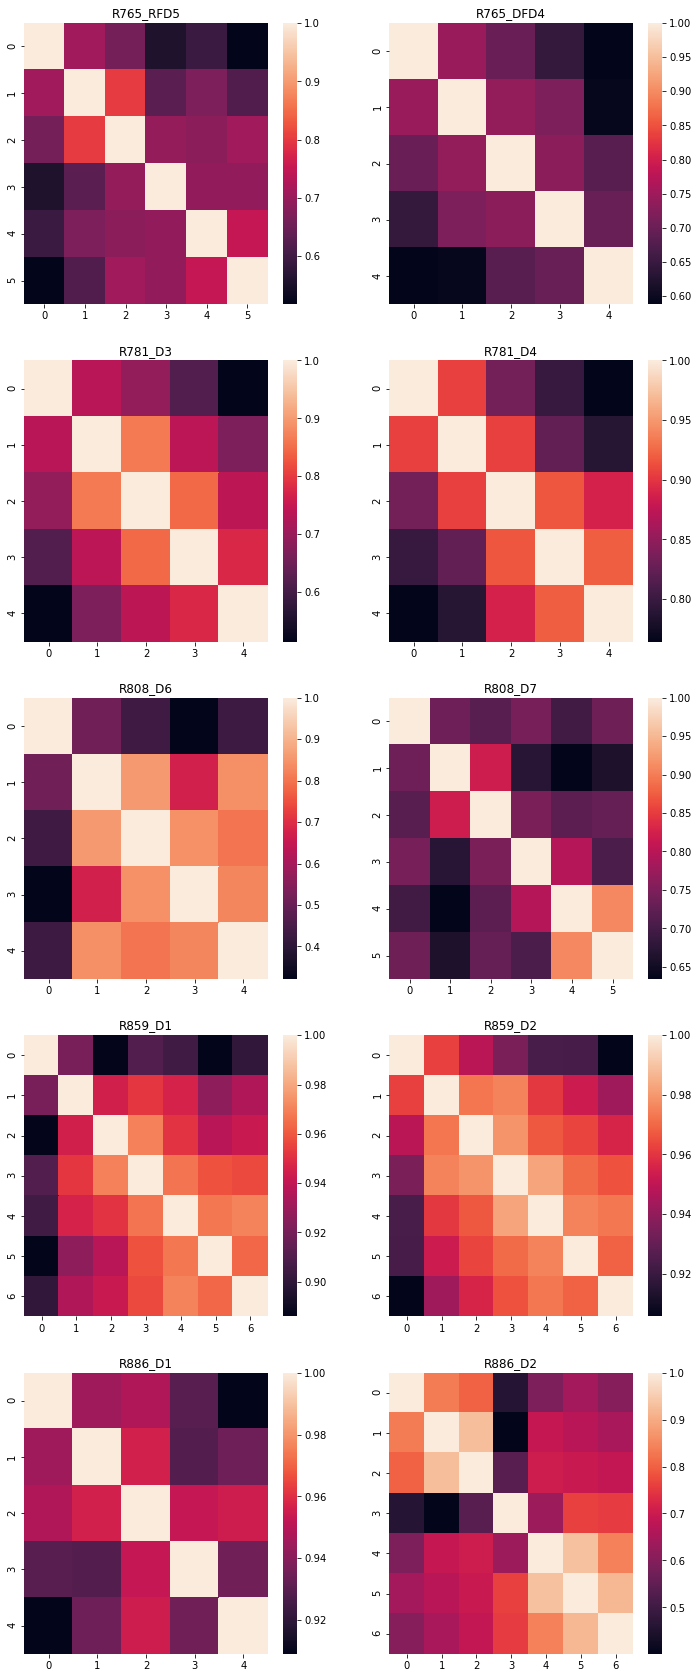

In [8]:
## Changes in representation with time
## Population vector correlation heatmaps
## x and y axis - time windows


fig, axs = plt.subplots(5,2, figsize = (12,30))
num_cells = []
all_rats = list(alldat.keys())
figy = 0
for rat in all_rats:
    all_days = list(alldat[rat].keys())
    figx = 0
    for day in all_days:
        day_neur = rat + '_' + day
        print(day_neur)
        anorm = np.load(store_dir + rat + '_' + day + '_time_alley_neur_normalized_.npy')
        anorm[anorm == np.inf] = np.NaN
       
        
        corr_plot = np.zeros((len(anorm), len(anorm)))
        for i in range(0, len(anorm)):
            for j in range(0, len(anorm)):
                if True not in np.isnan(anorm[i]) and True not in np.isnan(anorm[j]) and i!=j:
                    corr_plot[i,j] = scipy.stats.pearsonr(anorm[i].flatten(),anorm[j].flatten())[0]
                    
                else:
                    no_na_i = ~np.isnan(anorm[i].flatten())
                    no_na_j = ~np.isnan(anorm[j].flatten())
                    no_na = no_na_i*no_na_j
                    corr_plot[i,j] = scipy.stats.pearsonr(anorm[i].flatten()[no_na],anorm[j].flatten()[no_na])[0]
                    
        sb.heatmap(corr_plot, ax = axs[figy, figx])
        axs[figy, figx].set_title(rat + '_' + day)
        ##plt.show()
        figx = figx + 1
    figy = figy + 1

R765_RFD5
(6, 29, 22)
(6, 29, 22)
(0.27939939942988307, 0.13484416035964292)
SpearmanrResult(correlation=0.2014487493175891, pvalue=0.28575168238580234)
R765_DFD4
(5, 29, 32)
(5, 29, 31)
(0.524852596674795, 0.017498455149338846)
SpearmanrResult(correlation=0.507937813818488, pvalue=0.02222669791592755)
R781_D3
(5, 29, 17)
(5, 29, 17)
(0.1724376038333449, 0.46723646211937186)
SpearmanrResult(correlation=0.24453004293993214, pvalue=0.2987870212055387)
R781_D4
(5, 29, 10)
(5, 29, 10)
(0.3965754084348253, 0.08342495900366614)
SpearmanrResult(correlation=0.2958511630631278, pvalue=0.20534246932961853)
R808_D6
(5, 29, 10)
(5, 29, 10)
(0.5224587442373583, 0.018113798306035662)
SpearmanrResult(correlation=0.4818181818181819, pvalue=0.031462099648405246)
R808_D7
(6, 29, 9)
(6, 29, 8)
(0.28625571195620303, 0.1251378679927535)
SpearmanrResult(correlation=0.21789763698809766, pvalue=0.24738408687664296)
R859_D1
(7, 29, 24)
(7, 29, 22)
(0.5209167761396654, 0.0004048678133382764)
SpearmanrResult(cor

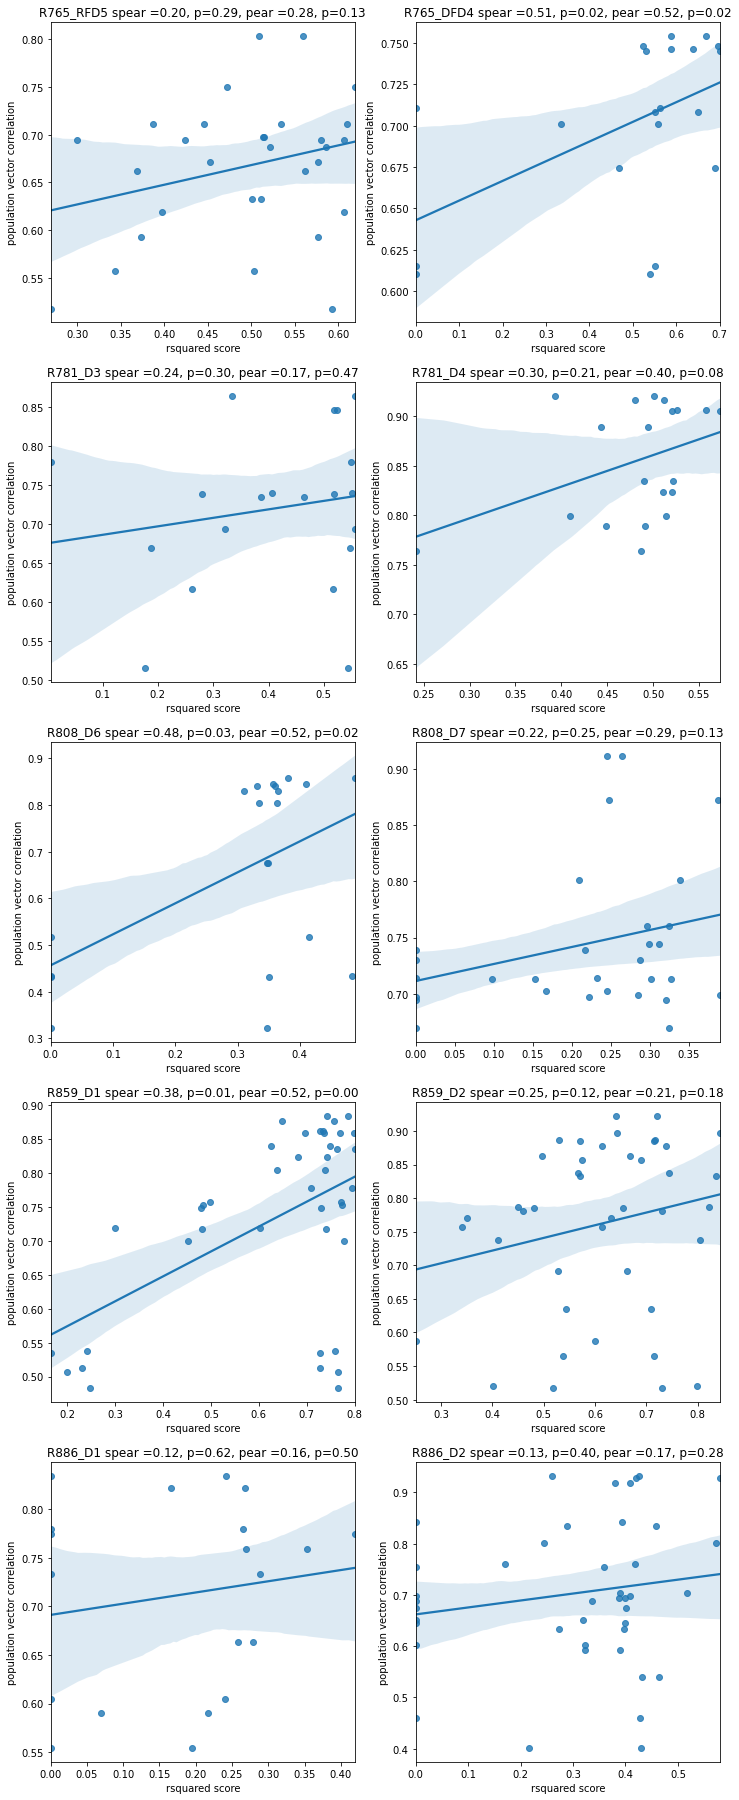

In [10]:
## pv correlation, regression score scatter plot
## can be modified to plot pv correlation vs decoder error
## can be modified to plot for x vs for y
## one plot for each rat-day pair

## Questions
## 1. Whether to limit to 0 or not
## 2. Interneurons removed

## parameters for finding interneurons
interneuron_thresh = 0.03 ##0.08
interneuron_num_alleys = 17

fig, axs = plt.subplots(5,2, figsize = (12,32))
##fig, axs = plt.subplots(9,1, figsize = (6,32))

num_cells = []
all_rats = list(alldat.keys())
figy = 0
all_pearson_corr =[]
all_pearson_p = []
all_spearman_corr =[]
all_spearman_p = []
all_rat_day = []
for rat in all_rats:
    all_days = list(alldat[rat].keys())
    figx = 0
    for day in all_days:
        
        
        day_neur = rat + '_' + day
        all_rat_day.append(day_neur)
        print(day_neur)
        x = np.load(store_dir + rat + '_' + day + '_x_within.npy')
        y = np.load(store_dir + rat + '_' + day + '_y_within.npy')
        inst_fr = np.load(store_dir+ rat + '_' + day + '_inst_fr.npy')
        anorm = np.load(store_dir + rat + '_' + day + '_time_alley_neur_normalized_.npy')
        anorm[anorm == np.inf] = np.NaN
        
        print(np.shape(anorm)) ## tells how many neurons were initially present
        
        ## excluding interneurons
        exclude_only = np.nanmean(anorm, axis = (0,1))> interneuron_thresh
        exclude_only= exclude_only*(np.sum(np.nanmean(anorm, axis = 0)>interneuron_thresh, axis = 0)>interneuron_num_alleys)
        include_only = ~exclude_only
        ## used to visualize interneurons which were excluded
        '''for ex in range(len(exclude_only)):
            if exclude_only[ex] == True:
                sb.heatmap(anorm[:,:,ex], ax = axs[figy])
                axs[figy].set_title(rat + '_' + day + '_' + str(ex))
                ##plt.show()
                figy = figy + 1'''
        
        anorm = anorm[:,:, include_only]
        
        print(np.shape(anorm)) ## tells how many neurons were included
        inst_fr[:,include_only]

        scaler = StandardScaler()
        inst_fr = scaler.fit_transform(inst_fr)

        dt = 10000
        buffer = 1000
        train_size = 80000
        num_cells.append(np.shape(anorm)[2])
        corr_score = []
        for i in range(0, len(anorm)):
            model = LinearRegression()
            X_train = inst_fr[i*dt+ buffer: i*dt+ buffer + train_size]
            y_train = x[i*dt+ buffer: i*dt+ buffer + train_size]
            model.fit(X_train, y_train)
            model2 = LinearRegression()
            y2_train = y[i*dt+ buffer: i*dt+ buffer + train_size]
            model2.fit(X_train, y2_train)
            for j in range(0, len(anorm)):
                X_test = inst_fr[j*dt: (j+1)*dt]
                y_test = x[j*dt: (j+1)*dt]
                y2_test = y[j*dt: (j+1)*dt]
                r2_score1 = model.score(X_test, y_test)
                r2_score2 = model2.score(X_test, y2_test)
                
                ## limiting to 0
                r2_score1 = np.maximum(r2_score1, 0)
                r2_score2 = np.maximum(r2_score2, 0)
                
                error = (np.mean((model.predict(X_test)-y_test)**2))**.5
                error2 = (np.mean((model2.predict(X_test)-y2_test)**2))**.5
                if True not in np.isnan(anorm[i]) and True not in np.isnan(anorm[j]) and i!=j:
                    cor_val = scipy.stats.pearsonr(anorm[i].flatten(),anorm[j].flatten())
                    corr_score.append(np.array([cor_val[0],r2_score1, r2_score2,error, error2]))
                elif i!=j:
                    no_na_i = ~np.isnan(anorm[i].flatten())
                    no_na_j = ~np.isnan(anorm[j].flatten())
                    no_na = no_na_i*no_na_j
                    cor_val = scipy.stats.pearsonr(anorm[i].flatten()[no_na],anorm[j].flatten()[no_na])
                    corr_score.append(np.array([cor_val[0],r2_score1, r2_score2,error, error2]))
        corr_score = np.array(corr_score)
        ##plt.plot(corr_score[:,0],corr_score[:,1],'o', label = day_neur)
        ##plt.plot(corr_score[:,2],corr_score[:,1],'o', label = day_neur)
        sb.regplot(corr_score[:,2],corr_score[:,0], ax = axs[figy, figx])
        print(scipy.stats.pearsonr(corr_score[:,2],corr_score[:,0]))
        print(scipy.stats.spearmanr(corr_score[:,2],corr_score[:,0]))
        spearman_corr = scipy.stats.spearmanr(corr_score[:,2],corr_score[:,0])
        pearson_corr = scipy.stats.pearsonr(corr_score[:,2],corr_score[:,0])
        all_pearson_corr.append(pearson_corr[0])
        all_pearson_p.append(pearson_corr[1])
        all_spearman_corr.append(spearman_corr[0])
        all_spearman_p.append(spearman_corr[1])
        
        axs[figy, figx].set_title(rat + '_' + day +' spear ='+ "{:.2f}".format(spearman_corr[0]) + ', p=' + "{:.2f}".format(spearman_corr[1]) + ', pear =' + "{:.2f}".format(pearson_corr[0]) + ', p=' + "{:.2f}".format(pearson_corr[1]))
        ##axs[figy, figx].set_xlabel('root-mean-squared-error')
        axs[figy, figx].set_xlabel('rsquared score')
        axs[figy, figx].set_ylabel('population vector correlation')

        figx = figx + 1
    figy = figy + 1
        
##plt.legend()

plt.show()


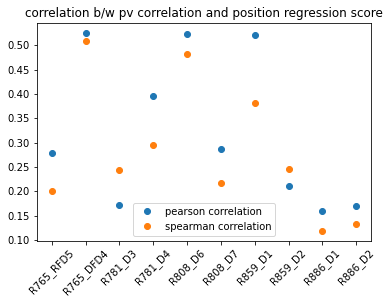

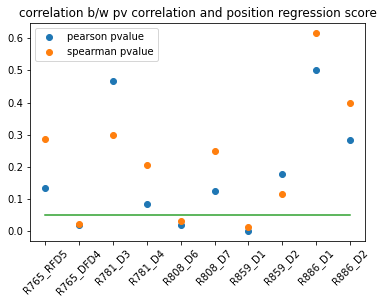

In [13]:
## Plots correlation b/w pv correlation and position regression score for each rat-day
## and respective pvalues (both pearson and spearman)

fig, ax = plt.subplots()
ax.plot(all_pearson_corr,'o', label = 'pearson correlation')
ax.plot(all_spearman_corr,'o', label = 'spearman correlation')
ax.set_xticks(np.arange(0, len(all_rat_day)))
ax.set_xticklabels(all_rat_day,rotation = 45)
##ax.set_ylim(0,1)

ax.legend()
ax.set_title('correlation b/w pv correlation and position regression score')

plt.show()

fig, ax = plt.subplots()
ax.plot(all_pearson_p,'o', label = 'pearson pvalue')
ax.plot(all_spearman_p,'o', label = 'spearman pvalue')
ax.set_xticks(np.arange(0, len(all_rat_day)))
ax.set_xticklabels(all_rat_day,rotation = 45)
ax.legend()
ax.plot([0.05]*len(all_rat_day))
ax.set_title('correlation b/w pv correlation and position regression score')
plt.show()

R765 RFD5
R765 DFD4
R781 D3
R781 D4
R808 D6
R808 D7
R859 D1
R859 D2
R886 D1
R886 D2


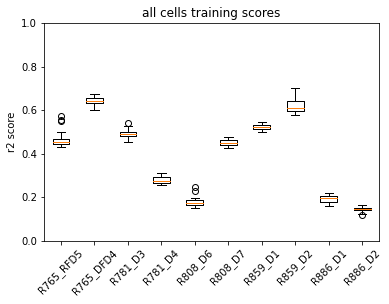

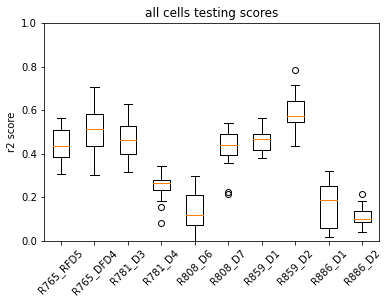

In [21]:
## Studying effect of repetition on decoding performance
## train on all timepoints, test on all timepoints
## takes buffer into account
## train size max 8000

## To include all neurons:
## include_repeat = False and include_nonrepeat = False

## To include only repeating neurons
##include_repeat = True and include_nonrepeat = False

## To include only non-repeating neurons
##include_repeat = False and include_nonrepeat = True

figcount = 0
dt = 10000
include_repeat = False
include_nonrepeat = False
all_num_repeat= []
all_num = []
all_rats = list(alldat.keys())
all_rat_day = []
all_train_scores = []
all_test_scores = []
for rat in all_rats:
    
    all_days = list(alldat[rat].keys())
    for day in all_days:
        print(rat, day)
        train_scores1 = []
        train_scores2 = []
        test_scores1 = []
        test_scores2 = []
        for rep in range(0,20):
            inst_fr = np.load(store_dir + rat + '_' + day + '_inst_fr.npy')
            x_order = np.load(store_dir + rat + '_' + day + '_x_within.npy')
            y_order = np.load(store_dir + rat + '_' + day + '_y_within.npy')
        
            shuff_start = np.random.choice(len(inst_fr),1)[0]
            shuff_inst_fr = np.vstack((inst_fr[shuff_start:,:], inst_fr[0:shuff_start,:]))
            inst_fr = shuff_inst_fr
            x = np.concatenate((x_order[shuff_start:], x_order[0:shuff_start]))
            y = np.concatenate((y_order[shuff_start:], y_order[0:shuff_start]))
            
            repeating_cells = []
            all_cells = alldat[rat][day]['units'].keys()
            for each_cell in all_cells:
                data = alldat[rat][day]['units'][each_cell]
                if data.repeating == True:
                    repeating_cells.append(True)
                else:
                    repeating_cells.append(False)
                    
            repeating_cells = np.array(repeating_cells)
            repeat_len = np.sum(repeating_cells)
            non_repeat_len = len(repeating_cells)- repeat_len
            
            if rep== 0:
                all_num_repeat.append(repeat_len)
                all_num_repeat.append(len(repeating_cells))
                
            if include_repeat == True:
                if repeat_len<non_repeat_len:
                    inst_fr = inst_fr[:,repeating_cells]
                else:
                    cells_chosen = np.random.choice(np.where(repeating_cells== True)[0],non_repeat_len)
                    inst_fr = inst_fr[:,cells_chosen]
                    
            elif include_nonrepeat == True:
                if repeat_len<non_repeat_len:
                    cells_chosen = np.random.choice(np.where(repeating_cells== False)[0],np.sum(repeating_cells))
                    inst_fr = inst_fr[:,cells_chosen]
                else:
                    inst_fr = inst_fr[:,~repeating_cells]

            ## it is possible there are no repeating cells    
            if len(inst_fr[0])!=0:
                ##print(len(inst_fr[0]))
                ##print(np.sum(repeating_cells))
                ##print(len(repeating_cells))
                if rep == 0:
                    all_rat_day.append(rat + '_' + day)

                target1 = x
                target1 = (target1-np.mean(target1))/np.std(target1)
                
                target2 = y
                target2 = (target2-np.mean(target2))/np.std(target2)

                ##all_train_sizes = np.arange(100,8000, 100)
                all_train_sizes = np.array([8000])
                for train_size in all_train_sizes:
                    test_size = 1000
                    buffer = int((dt-train_size-test_size)/2)
                    for i in range(0, int(len(inst_fr)/dt)):
                        ##print(i)
                        ##print('doing')
                        if i == 0:
                            ##print('training', i*dt, i*dt + train_size)
                            X_train = inst_fr[i*dt : i*dt + train_size,:]
                            y_train1 = target1[i*dt : i*dt + train_size]
                            y_train2 = target2[i*dt : i*dt + train_size]
                            X_test = inst_fr[(i)*dt + train_size + buffer: (i)*dt + train_size + buffer+test_size,:]
                            y_test1 = target1[(i)*dt + train_size + buffer: (i)*dt + train_size + buffer+test_size]
                            y_test2 = target2[(i)*dt + train_size + buffer: (i)*dt + train_size + buffer+test_size]
                            ##print('testing', (i)*dt + train_size + buffer,(i)*dt + train_size + buffer+test_size )
                        else:
                            X_train  = np.vstack((X_train, inst_fr[i*dt + buffer: i*dt + train_size+ buffer]))
                            ##print('training', i*dt + buffer,i*dt + train_size+ buffer)
                            X_test = np.vstack((X_test, inst_fr[(i)*dt + train_size + 2*buffer: (i)*dt + train_size + 2*buffer+test_size,:]))
                            ##print('testing',(i)*dt + train_size + 2*buffer,((i)*dt + train_size + 2*buffer+test_size))
                            y_train1 = np.append(y_train1, target1[i*dt+ buffer: i*dt + train_size+ buffer])
                            y_test1 = np.append(y_test1, target1[(i)*dt + train_size + 2*buffer: (i)*dt + train_size + 2*buffer+test_size])

                            y_train2 = np.append(y_train2, target2[i*dt+ buffer: i*dt + train_size+ buffer])
                            y_test2 = np.append(y_test2, target2[(i)*dt + train_size + 2*buffer: (i)*dt + train_size + 2*buffer+test_size])

                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_test = scaler.transform(X_test)        

                    model = LinearRegression()
                    model.fit(X_train, y_train1)
                    
                    model2 = LinearRegression()
                    model2.fit(X_train, y_train2)

                    ##train_scores1.append(model.score(X_train, y_train1))
                    train_scores1.append(r2_score(y_train1,model.predict(X_train)))
                    ##test_scores1.append(model.score(X_test, y_test1))
                    test_scores1.append(r2_score(y_test1, model.predict(X_test)))
                    train_scores2.append(model2.score(X_train, y_train2))
                    test_scores2.append(model2.score(X_test, y_test2))
 
        train_scores1 = np.array(train_scores1)
        test_scores1 = np.array(test_scores1)
        train_scores2 = np.array(train_scores2)
        test_scores2 = np.array(test_scores2)
        all_train_scores.append(train_scores1)
        all_test_scores.append(test_scores1)
        
fig, ax = plt.subplots()
ax.boxplot(all_train_scores)
ax.set_xticklabels(all_rat_day,rotation = 45)
ax.set_ylim(0,1)
ax.set_title('all cells training scores')
ax.set_ylabel('r2 score')
plt.show()
fig, ax = plt.subplots()
ax.boxplot(all_test_scores)

ax.set_xticklabels(all_rat_day,rotation = 45)
ax.set_ylim(0,1)
ax.set_title('all cells testing scores')
ax.set_ylabel('r2 score')

plt.show()


(79107, 39)
starting 0 20000
starting 5000 25000
starting 10000 30000


KeyboardInterrupt: 

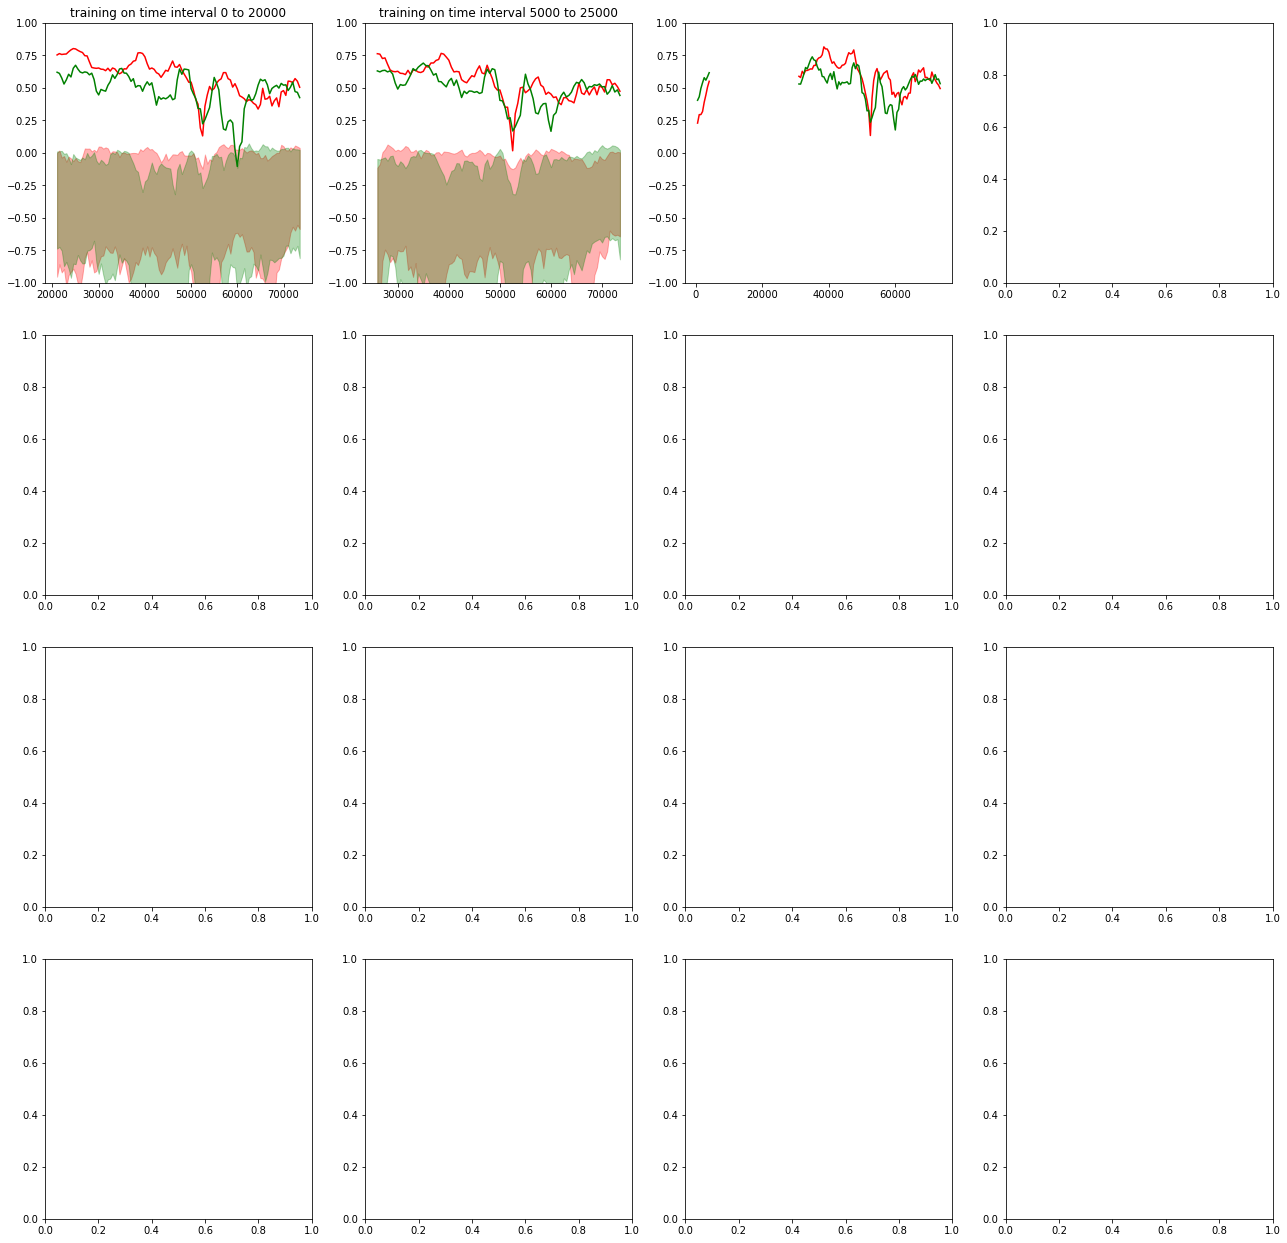

In [25]:
## Decoding position by training on limited time window
## circular shuffle permutation test

inst_fr = np.load(store_dir + 'R859_D2_inst_fr_within.npy')

x = np.load(store_dir + 'R859_D2_x_pos_within.npy')
y = np.load(store_dir + 'R859_D2_y_pos_within.npy')


##if len(inst_fr)< 100:
    ##inst_fr = inst_fr.T

fig, axs = plt.subplots(4,4,figsize=(22,22))

scaler = StandardScaler()
inst_fr = scaler.fit_transform(inst_fr)

print(np.shape(inst_fr))

dt = 5000##10000
train_size = 20000##16000
buffer = 1000
test_size = 5000
window = 500

num_shuffles = 500
alpha_val = 0.3

nrepeats = 1
##for i in range(0, 2):##int(np.floor(len(inst_fr)/dt))):
for i in range(0, int(np.floor((len(inst_fr)-train_size)/dt))):
    print('starting',i*dt, i*dt+ train_size)
    all_xtest_scores= []
    all_xtest_scores_other = []
    all_ytest_scores= []
    all_ytest_scores_other = []
    for shuffling in range(-1, num_shuffles):
        ##print(shuffling)
        inst_fr = np.load(store_dir + 'R859_D2_inst_fr_within.npy')
        if shuffling>=0:
            shuff_start = np.random.choice(len(inst_fr),1)[0]
            shuff_inst_fr = np.vstack((inst_fr[shuff_start:,:], inst_fr[0:shuff_start,:]))
            inst_fr = shuff_inst_fr
        
        xtest_scores= []
        xtest_scores_other = []
        X_train = inst_fr[i*dt: (i)*dt+ train_size]
        y_train = x[i*dt: (i)*dt+ train_size]
        model = LinearRegression()
        model.fit(X_train, y_train)

        ytest_scores= []
        ytest_scores_other = []
        model2 = LinearRegression()
        y_train = y[i*dt: (i)*dt+ train_size]
        model2.fit(X_train, y_train)

        all_starts = []
        start = (i)*dt+ train_size + buffer
        ##print(shuffling, start)
        while start + window + test_size < len(inst_fr):
            ##print('late',start,start + test_size )
            ##if start< 56000 or start> 58000:
                ##xtest_scores.append(model.score( inst_fr[start: start + test_size],x[start: start + test_size]))
                ##ytest_scores.append(model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size]))
                ##if ytest_scores[-1]<-5 and i!= 0:
                    ##print(i, start, ytest_scores[-1])

                ##all_starts.append(start)
            all_starts.append(start)
            
            xtest_scores.append(model.score( inst_fr[start: start + test_size],x[start: start + test_size]))
            ytest_scores.append(model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size]))
            ##xtest_scores.append(np.mean(model.predict( inst_fr[start: start + test_size])-x[start: start + test_size])**2)
            ##ytest_scores.append(np.mean(model2.predict(inst_fr[start: start + test_size])-y[start: start + test_size])**2)
            
            start = start + window


        all_starts_other = []
        start = (i)*dt- buffer-test_size 
        while start >0:
            ##print('early', start, start+test_size)
            xtest_scores_other.append(model.score( inst_fr[start: start + test_size],x[start: start + test_size]))
            ytest_scores_other.append(model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size]))
            ##xtest_scores_other.append((np.mean(model.predict( inst_fr[start: start + test_size])-x[start: start + test_size])**2)**.5)
            ##ytest_scores_other.append((np.mean(model2.predict(inst_fr[start: start + test_size])-y[start: start + test_size])**2)**.5)
            
            
            all_starts_other.append(start)
            start = start - window
        
        if shuffling == 0:
            all_xtest_scores = np.zeros((num_shuffles, len(xtest_scores)))
            all_xtest_scores_other = np.zeros((num_shuffles, len(xtest_scores_other)))
            all_ytest_scores = np.zeros((num_shuffles, len(ytest_scores)))
            all_ytest_scores_other = np.zeros((num_shuffles, len(ytest_scores_other)))
        if shuffling>0:    
            all_xtest_scores[shuffling] = np.array(xtest_scores)
            all_xtest_scores_other[shuffling] = np.array(xtest_scores_other)
            all_ytest_scores[shuffling] = np.array(ytest_scores)
            all_ytest_scores_other[shuffling] = np.array(ytest_scores_other)
        
        if shuffling <0:
            axs[int(np.floor(i/4)),i%4].plot(all_starts, xtest_scores, color = 'red')
            axs[int(np.floor(i/4)),i%4].plot(all_starts, ytest_scores, color = 'green')
            axs[int(np.floor(i/4)),i%4].plot(all_starts_other, xtest_scores_other,color = 'red')
            axs[int(np.floor(i/4)),i%4].plot(all_starts_other, ytest_scores_other,color = 'green')
            axs[int(np.floor(i/4)),i%4].set_ylim(-1, 1)
    
    alpha = 0.05
    each_side = int((alpha/2)*num_shuffles)

    all_xtest_scores= np.array(all_xtest_scores)
    all_xtest_scores_other= np.array(all_xtest_scores_other)
    all_ytest_scores= np.array(all_ytest_scores)
    all_ytest_scores_other= np.array(all_ytest_scores_other)
    CI_95x1 = np.sort(all_xtest_scores, axis = 0)[-each_side]
    CI_95y1 = np.sort(all_ytest_scores, axis = 0)[-each_side]
    CI_95x0 = np.sort(all_xtest_scores, axis = 0)[each_side]
    CI_95y0 = np.sort(all_ytest_scores, axis = 0)[each_side]
    CI_95x_other1 = np.sort(all_xtest_scores_other, axis = 0)[-each_side]
    CI_95y_other1 = np.sort(all_ytest_scores_other, axis = 0)[-each_side]
    CI_95x_other0 = np.sort(all_xtest_scores_other, axis = 0)[each_side]
    CI_95y_other0 = np.sort(all_ytest_scores_other, axis = 0)[each_side]
    
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts, CI_95x0,CI_95x1, alpha = alpha_val, color = 'red')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts, CI_95y0,CI_95y1,alpha = alpha_val, color = 'green')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts_other, CI_95x_other0,CI_95x_other1,alpha = alpha_val,color = 'red')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts_other, CI_95y_other0,CI_95y_other1,alpha = alpha_val,color = 'green')
    
    '''axs[int(np.floor(i/4)),i%4].plot(all_starts, CI_95x0, color = 'black')
    axs[int(np.floor(i/4)),i%4].plot(all_starts, CI_95y0, color = 'black')
    axs[int(np.floor(i/4)),i%4].plot(all_starts_other, CI_95x_other0,color = 'red')
    axs[int(np.floor(i/4)),i%4].plot(all_starts_other, CI_95y_other0,color = 'green')'''
    
    '''axs[int(np.floor(i/4)),i%4].fill_between(all_starts, CI_95x0,50, alpha = alpha_val, color = 'red')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts, CI_95y0,50,alpha = alpha_val, color = 'green')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts_other,CI_95x_other0,50,alpha = alpha_val,color = 'red')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts_other, CI_95y_other0,50,alpha = alpha_val,color = 'green')'''
    
    axs[int(np.floor(i/4)),i%4].set_ylim(-1, 1)
    axs[int(np.floor(i/4)),i%4].set_title('training on time interval '+ str(i*dt)+ ' to ' + str(i*dt + train_size))

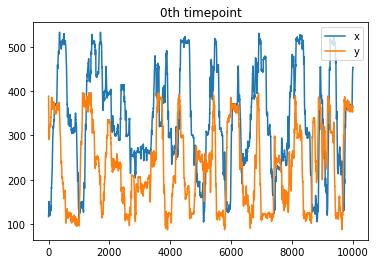

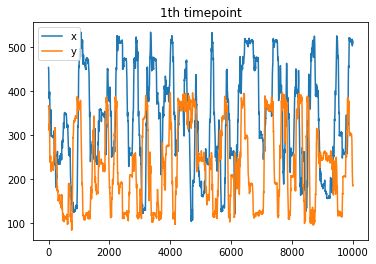

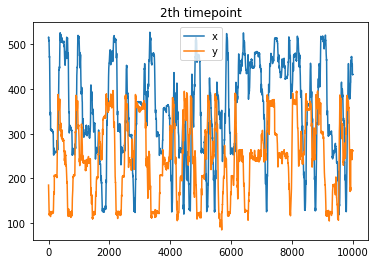

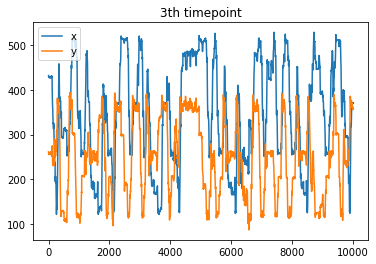

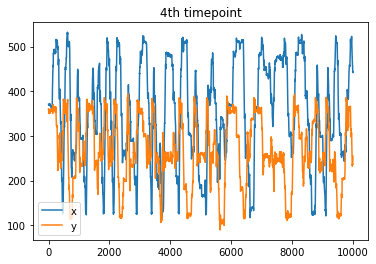

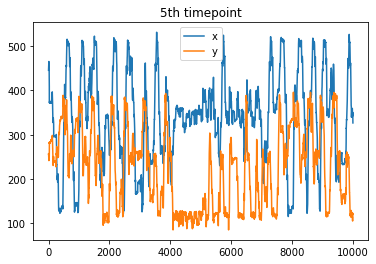

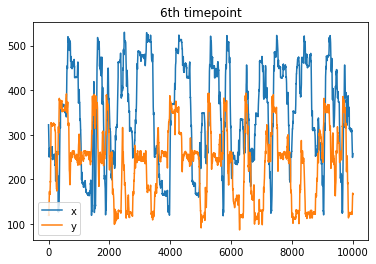

In [9]:
## Extras
## Finding potential issues with behavior, that is affecting decoding

rat = 'R859'
day = 'D2'
x = np.load(store_dir + rat + '_' + day + '_x_within.npy')
y = np.load(store_dir + rat + '_' + day + '_y_within.npy')
for i in range(0, 7):
    plt.plot(x[i*dt:(i+1)*dt], label = 'x')
    plt.plot(y[i*dt:(i+1)*dt], label = 'y')
    plt.title(str(i) + 'th timepoint')
    plt.legend()
    plt.show()


D1


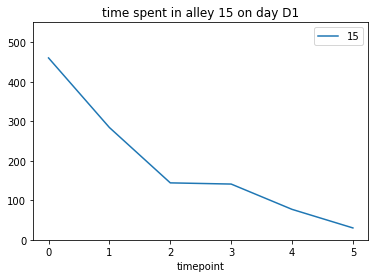

D2


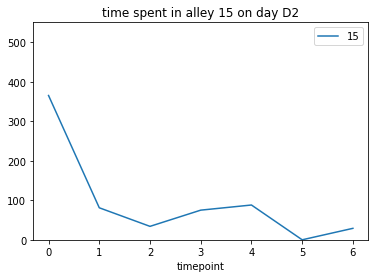

In [22]:
## Changes in behavior
## Learning to avoid alley 15
## For rat R859 D1, and D2

rat = 'R859'
all_days = list(alldat[rat].keys())
for day in all_days:
    print(day)

    all_cells = list(alldat[rat][day]['units'].keys())
    data = alldat[rat][day]['units'][all_cells[0]]
    time_counter = 0
    time_spent_alley = np.zeros(len(bound_list))
    all_time_spent_alley = np.zeros(len(bound_list))
    for i in range(len(data.position)):
        curr_time = data.position[i, 0]
        x = data.position[i, 1]
        y = data.position[i, 2]
        found = False
        
        for j in range(len(bound_list)): 
            alley = bound_list[j]
            if x > boundaries[alley][0][0] and x<= boundaries[alley][0][1]:
                if y>boundaries[alley][1][0] and y<= boundaries[alley][1][1]:
                    time_spent_alley[j] = time_spent_alley[j] + 1
                    found = True
                    time_counter = time_counter + 1
                    if time_counter> dt:
                        all_time_spent_alley = np.vstack((all_time_spent_alley, time_spent_alley))
                        timebreaks.append(curr_time)
                        time_counter = 0
                        time_spent_alley = np.zeros(len(bound_list))
                        
                    break
                    
    all_time_spent_alley= all_time_spent_alley[1:]
    for i in [15]:
        plt.plot(all_time_spent_alley[:,i], label = i)
        plt.xlabel('timepoint')
        plt.title('time spent in alley 15 on day ' + day)
    plt.legend()
    plt.ylim(0, 550)
    plt.show()



In [ ]:
## Changes in behavior
## Learning to avoid alley 15
## Need to calculate separately for R859 D3, since data not processed

datadir = '/DATA/R859_RatterdamOpen_D3/'
tetrode = 'TT10/'
eachfile = 'cl-maze1.1'
dt = 10000
data = CoreFx.loadRepeatingUnit(datadir, tetrode + eachfile, tetrode + eachfile)
alltime = np.array(data.position)[:,0]
time_spent_alley = np.zeros(len(bound_list))
all_time_spent_alley = np.zeros(len(bound_list))
time_counter = 0
timebreaks = []
for i in range(len(data.position)):
    curr_time = data.position[i, 0]
    x = data.position[i, 1]
    y = data.position[i, 2]
    found = False
    
    
    for j in range(len(bound_list)): 
        alley = bound_list[j]
        if x > boundaries[alley][0][0] and x<= boundaries[alley][0][1]:
            if y>boundaries[alley][1][0] and y<= boundaries[alley][1][1]:
                time_spent_alley[j] = time_spent_alley[j] + 1
                found = True
                time_counter = time_counter + 1
                if time_counter> dt:
                    all_time_spent_alley = np.vstack((all_time_spent_alley, time_spent_alley))
                    timebreaks.append(curr_time)
                    time_counter = 0
                    time_spent_alley = np.zeros(len(bound_list))

                break

all_time_spent_alley= all_time_spent_alley[1:]
for i in [15]:
    plt.plot(all_time_spent_alley[:,i], label = i)
plt.legend()
plt.ylim(0, 550)
plt.xlabel('timepoint')
plt.title('time spent in alley 15 on day ' + 'D3')
plt.show()